In [1]:
import torch
import torch.nn as nn
import librosa
import librosa.display
import os
import numpy as np
from IPython.display import Audio
from scipy import signal
import torch.nn.functional as F
import matplotlib.pyplot as plt
import soundfile as sf

In [2]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.norm_1 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_2 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.1)
        self.feed_fwd_net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, x):
        attention_output, _ = self.mha(x, x, x)
        out = self.dropout_1(attention_output)
        out = self.norm_1(out + x)
        # 
        ffn_out = self.feed_fwd_net(out)
        ffn_out = self.dropout_2(ffn_out)
        out = self.norm_2(out + ffn_out)
        return out

class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, n_enc_blcks = 9, device = "cpu"):
        super(Encoder, self).__init__()
        self.mha_list = nn.ModuleList([
            EncoderBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(n_enc_blcks)
        ]).to(device)
    
    def forward(self, x):
        out = self.mha_list[0](x)
        for encoder_blck in self.mha_list:
            out = encoder_blck(out)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(DecoderBlock, self).__init__()
        self.mha_1 = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.mha_2 = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.norm_1 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_2 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.norm_3 = nn.LayerNorm((embed_dim), eps=1e-6)
        self.dropout_1 = nn.Dropout(p=0.1)
        self.dropout_2 = nn.Dropout(p=0.1)
        self.dropout_3 = nn.Dropout(p=0.1)
        self.feed_fwd_net = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x, encoded_x):
        attention_output, _ = self.mha_1(x, x, x)
        out = self.dropout_1(attention_output)
        out = self.norm_1(out + x)
        # 
        out_mha2, _ = self.mha_2(encoded_x, encoded_x, x)
        out_mha2 = self.dropout_2(out_mha2)
        out = self.norm_2(out_mha2 + out)
        # 
        ffn_out = self.feed_fwd_net(out)
        ffn_out = self.dropout_3(ffn_out)
        out = self.norm_3(ffn_out + out)
        return out

class Decoder(nn.Module):
    def __init__(self, embed_dim, num_heads, n_dec_blcks = 6, device = "cpu"):
        super(Decoder, self).__init__()
        self.decoder_list = nn.ModuleList([
            DecoderBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(n_dec_blcks)
        ]).to(device)

    def forward(self, x, encoded_x):
        for decoder_blck in self.decoder_list:
            x = decoder_blck(x, encoded_x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, embed_dim, num_heads, n_enc_blcks = 9, n_dec_blcks = 9, device = "cpu"):
        super(TransformerModel, self).__init__()
        self.encoder = Encoder(embed_dim=embed_dim, num_heads=num_heads, n_enc_blcks=n_enc_blcks, device = device)
        self.decoder = Decoder(embed_dim=embed_dim, num_heads=num_heads, n_dec_blcks=n_dec_blcks, device = device)
    
    def forward(self, x_src, x_trg):
        enc_out = self.encoder(x_src)
        dec_out = self.decoder(x_trg, enc_out)
        return dec_out

In [3]:
FRAME_SHIFT = 0.0125
FRAME_LENGTH = 0.05
SAMPLE_RATE = 16000
TOP_DB = 15
PREEMHPASIS = 0.97
N_FFT = 2048
HOP_LENGTH = int(SAMPLE_RATE*FRAME_SHIFT)
WIN_LENTGH = int(SAMPLE_RATE*FRAME_LENGTH)
N_MELS = 512
REF_DB = 20
MAX_DB = 100

def load_wave(file_path, sr=SAMPLE_RATE):
    y, sr = librosa.load(file_path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB)
    linear = librosa.stft(y=y,
                          n_fft=N_FFT)
    amplitude, phase = np.abs(linear), np.angle(linear)
    return amplitude, phase


def convert_to_complex(amplitude, phase):
    return amplitude * np.vectorize(complex)(np.cos(phase), np.sin(phase))

def to_decibel(S, ref = 1.0, eps = 1e-9):
    return 10 * np.log10(S / ref + eps)

def decibel_revert(db):
    return 10 ** (db / 10)

def infinite_iter(loader):
    it = iter(loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(loader)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def signal_pad(source, target_len = 128):
    if source.shape[-1] >= target_len:
        return source[:, :target_len]
    else:
        padding = np.zeros((source.shape[0], target_len - source.shape[1]), dtype = source.dtype) + 1e-5  
        return np.concatenate([source, padding], axis = 1)

def normalize(source, target):
    mean = np.mean(np.hstack([source, target]))
    std = np.std(np.hstack([source, target]))
    normalized_source = (source - mean) / std
    normalized_target = (target - mean) / std
    return normalized_source, normalized_target, mean, std

def denormalize(source, target, mean, std):
    source = (source.numpy() * std) + mean
    target = (target.numpy() * std) + mean
    return source, target

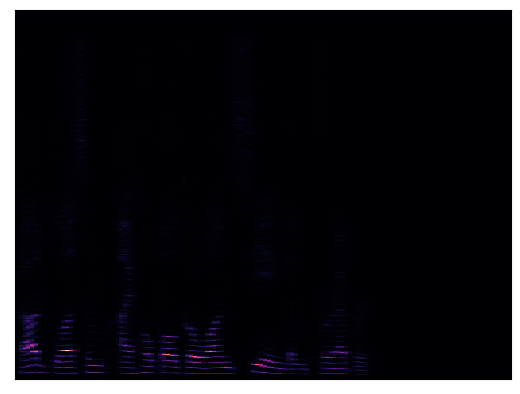

In [4]:
path = os.path.join("..", "spk_data", "speaker2", "arctic_a0006.wav")
amp, phase = load_wave(path)
amp = signal_pad(amp, target_len = 128)
phase = signal_pad(phase, target_len = 128)
amp = to_decibel(amp)
amp = decibel_revert(amp)
librosa.display.specshow(amp)
voice_stft = convert_to_complex(amp, phase)
voice = librosa.istft(voice_stft)
Audio(voice, rate = SAMPLE_RATE)

In [5]:
CONFIG = {
    "model": {
        "embed_dim": 128,
        "num_heads": 4,
        "n_enc_blcks": 9,
        "n_dec_blcks": 6
    },
    "optimizer": {
        "lr": 1e-5,
        "beta1": 0.9,
        "beta2": 0.98,
        "weight_decay": 0.0001
    },
    "dataset_path": "../data/data",
    "data_loader": {
        "batch_size": 32
    },
    "n_iterations": 50000,
    "save_frequency": 10000
}

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = os.path.join("..", "models", "transformer-vc-transposed", "model_save_iter_40000.ckpt")

model = TransformerModel(
    embed_dim = CONFIG["model"]["embed_dim"],
    num_heads = CONFIG["model"]["num_heads"],
    n_enc_blcks = CONFIG["model"]["n_enc_blcks"],
    n_dec_blcks = CONFIG["model"]["n_dec_blcks"],
    device = DEVICE
)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [7]:
test_tensor = torch.rand((1, 1025, 128)).to(DEVICE)
with torch.no_grad():
    test = model(test_tensor, test_tensor)
test.shape

torch.Size([1, 1025, 128])

In [8]:
source_speaker = "speaker2"
target_speaker = "speaker7"
source_sample = "arctic_a0012.wav"
target_sample = "arctic_a0012.wav"

SOURCE_SPEECH = os.path.join("..", "spk_data", source_speaker, source_sample)
TARGET_SPEECH = os.path.join("..", "spk_data", target_speaker, target_sample)

CONFIG_PATH = "config.json"

SRC_TARGET_CONVERSION = os.path.join("conversions", f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join("conversions", f"{target_speaker}_{source_speaker}_{target_sample}")

source_amp, source_phase = load_wave(SOURCE_SPEECH)
target_amp, target_phase = load_wave(TARGET_SPEECH)

source_amp = signal_pad(source_amp, target_len = 128)
source_phase = signal_pad(source_phase, target_len = 128)
target_amp = signal_pad(target_amp, target_len = 128)
target_phase = signal_pad(target_phase, target_len = 128)

source_speech, _ = librosa.load(SOURCE_SPEECH, sr=SAMPLE_RATE)
target_speech, _ = librosa.load(TARGET_SPEECH, sr=SAMPLE_RATE)
source_speech, _ = librosa.effects.trim(source_speech, top_db=TOP_DB)
target_speech, _ = librosa.effects.trim(target_speech, top_db=TOP_DB)

source_amp = to_decibel(source_amp)
target_amp = to_decibel(target_amp)

source_amp, target_amp, mean, std = normalize(source_amp, target_amp)
x_src, x_trg = torch.from_numpy(source_amp).to(DEVICE).unsqueeze(0), torch.from_numpy(target_amp).to(DEVICE).unsqueeze(0)

with torch.no_grad():
    src_to_trg = model(x_src, x_trg)
    trg_to_src = model(x_trg, x_src)

src_to_trg = (src_to_trg.cpu().squeeze(0).numpy() * std) + mean
trg_to_src = (trg_to_src.cpu().squeeze(0).numpy() * std) + mean

src_to_trg = decibel_revert(src_to_trg)
trg_to_src = decibel_revert(trg_to_src)

src_trg_conversion = convert_to_complex(src_to_trg, source_phase)
trg_src_conversion = convert_to_complex(trg_to_src, target_phase)

src_trg_conversion = librosa.istft(src_trg_conversion)
trg_src_conversion = librosa.istft(trg_src_conversion)
#
Audio(np.hstack([src_trg_conversion, np.zeros(30), target_speech]), rate = SAMPLE_RATE)

In [9]:
Audio(np.hstack([trg_src_conversion, np.zeros(30), source_speech]), rate = SAMPLE_RATE)

In [10]:
Audio(source_speech, rate = SAMPLE_RATE)

In [11]:
Audio(target_speech, rate = SAMPLE_RATE)

In [12]:
#

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH_NO_DECIBEL = os.path.join("..", "models", "transformer-vc-transposed", "model_save_iter_30000_no_log.ckpt")

model = TransformerModel(
    embed_dim = CONFIG["model"]["embed_dim"],
    num_heads = CONFIG["model"]["num_heads"],
    n_enc_blcks = CONFIG["model"]["n_enc_blcks"],
    n_dec_blcks = CONFIG["model"]["n_dec_blcks"],
    device = DEVICE
)
model.load_state_dict(torch.load(MODEL_PATH_NO_DECIBEL))

<All keys matched successfully>

In [14]:
source_speaker = "speaker2"
target_speaker = "speaker3"
source_sample = "arctic_a0012.wav"
target_sample = "arctic_a0012.wav"

SOURCE_SPEECH = os.path.join("..", "spk_data", source_speaker, source_sample)
TARGET_SPEECH = os.path.join("..", "spk_data", target_speaker, target_sample)

CONFIG_PATH = "config.json"

SRC_TARGET_CONVERSION = os.path.join("conversions", f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join("conversions", f"{target_speaker}_{source_speaker}_{target_sample}")

source_amp, source_phase = load_wave(SOURCE_SPEECH)
target_amp, target_phase = load_wave(TARGET_SPEECH)

source_amp = signal_pad(source_amp, target_len = 128)
source_phase = signal_pad(source_phase, target_len = 128)
target_amp = signal_pad(target_amp, target_len = 128)
target_phase = signal_pad(target_phase, target_len = 128)

source_speech, _ = librosa.load(SOURCE_SPEECH, sr=SAMPLE_RATE)
target_speech, _ = librosa.load(TARGET_SPEECH, sr=SAMPLE_RATE)
source_speech, _ = librosa.effects.trim(source_speech, top_db=TOP_DB)
target_speech, _ = librosa.effects.trim(target_speech, top_db=TOP_DB)

# source_amp = to_decibel(source_amp)
# target_amp = to_decibel(target_amp)

source_amp, target_amp, mean, std = normalize(source_amp, target_amp)
x_src, x_trg = torch.from_numpy(source_amp).to(DEVICE).unsqueeze(0), torch.from_numpy(target_amp).to(DEVICE).unsqueeze(0)

with torch.no_grad():
    src_to_trg = model(x_src, x_trg)
    trg_to_src = model(x_trg, x_src)

src_to_trg = (src_to_trg.cpu().squeeze(0).numpy() * std) + mean
trg_to_src = (trg_to_src.cpu().squeeze(0).numpy() * std) + mean

# src_to_trg = decibel_revert(src_to_trg)
# trg_to_src = decibel_revert(trg_to_src)

src_trg_conversion = convert_to_complex(src_to_trg, source_phase)
trg_src_conversion = convert_to_complex(trg_to_src, target_phase)

src_trg_conversion = librosa.istft(src_trg_conversion)
trg_src_conversion = librosa.istft(trg_src_conversion)
#
Audio(np.hstack([src_trg_conversion, np.zeros(30), target_speech]), rate = SAMPLE_RATE)

In [15]:
Audio(np.hstack([trg_src_conversion, np.zeros(30), source_speech]), rate = SAMPLE_RATE)